In [109]:
import tensorflow as tf
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['paper' 'rock' 'scissors']
Corresponding label : paper


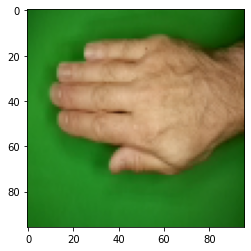

In [110]:
%load_ext autoreload
%autoreload 2

from utilities.script.image_utils import load_samples, show_image_number
from utilities.script.image_utils import show_classification_result

# Load image sample
sample_images, sample_ground_truth = load_samples(size=(96, 96))
show_image_number(sample_images[0], sample_ground_truth[0])

In [111]:
#len(sample_images)

In [112]:
# Convert to categorical

sample_ground_truth = tf.keras.utils.to_categorical(sample_ground_truth, num_classes=3)

In [113]:
# Load Model
MODEL_PATH = "weight/shallow/"
SAVED_WEIGHT_NAME = "shallow_4.h5"
SAVED_CONFIGURATION_NAME = "shallow_4.json"

json_file = open(MODEL_PATH + SAVED_CONFIGURATION_NAME, 'r')
loaded_model_json = json_file.read()
json_file.close()
classifier = tf.keras.models.model_from_json(loaded_model_json)


classifier.load_weights(MODEL_PATH + SAVED_WEIGHT_NAME)

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

In [114]:
def generate_adversary_example(model, image, label, epsilon=2/255.0):
    image = tf.cast(image, dtype=tf.float32)
    cross_entropy = tf.keras.losses.CategoricalCrossentropy()

    with tf.GradientTape() as tape:
        tape.watch(image)

        pred = model(image)
        loss = cross_entropy(label, pred)

        gradient = tape.gradient(loss, image)
        signed_gradient = tf.sign(gradient)

        adversary_example = (image + (signed_gradient * epsilon)).numpy()

        return adversary_example

In [117]:
real_images = []
adversary_images = []

real_images_label = []
adversary_images_label = []

for idx, sample_image in enumerate(sample_images):
    # Get material for FGSM
    image = np.expand_dims(sample_images[idx], axis=0)
    label = np.expand_dims(sample_ground_truth[idx], axis=0)

    # Generate FGSM sample and do prediction
    adversary_example = generate_adversary_example(model=classifier, image=image, label=label, epsilon=0.1)
    pred = classifier.predict(adversary_example)
    pred_real = classifier.predict(image)

    # Reshaping non-adversary sample and adversary sample into 255 RGB format
    adversary_example = adversary_example.reshape((96, 96, 3)) * 255
    adversary_example = np.clip(adversary_example, 0, 255).astype('uint8')

    image = image.reshape((96, 96, 3)) * 255
    image = image.astype("uint8")

    real_images.append(image)
    adversary_images.append(adversary_example)

    real_images_label.append(pred_real[0])
    adversary_images_label.append(pred[0])


1/1 [==============================] - 0s 20ms/step


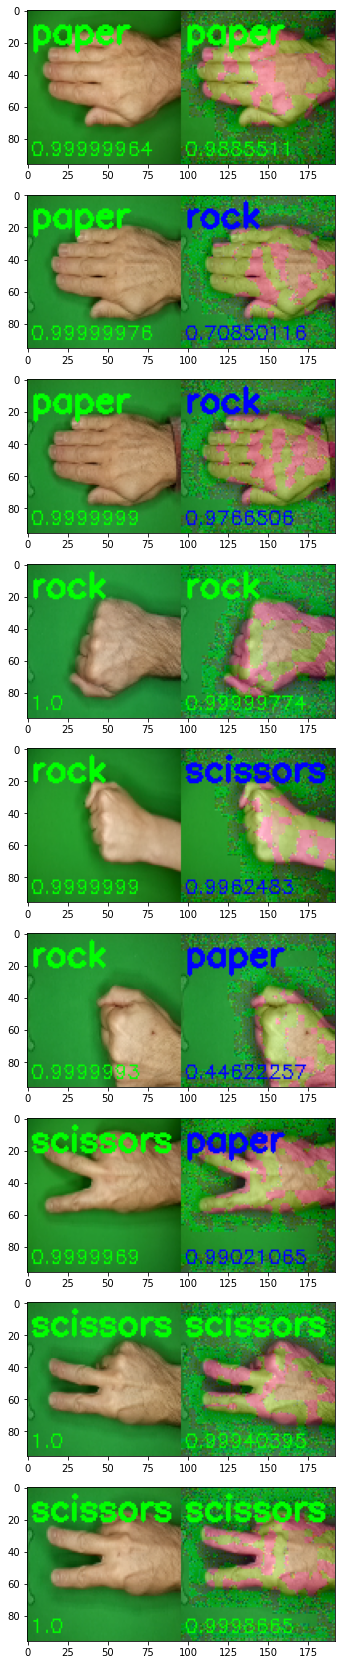

In [118]:
show_classification_result(images=real_images, adversaries=adversary_images, labels=real_images_label, adversary_labels=adversary_images_label)